## Import required Librarys

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import tensorflow_hub as hub
import numpy as np
import cv2 

## Usefull functions

### function showing progres in learning of the model

In [2]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

### function to make preatty confusion_matrix

In [3]:

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 

  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

## Preparing data

In [4]:
train_path = 'C:/Users/48517/Desktop/ML/project_vol2/gesture/train'
test_path = 'C:/Users/48517/Desktop/ML/project_vol2/gesture/test'
valid_path = 'C:/Users/48517/Desktop/ML/project_vol2/gesture/validate'

In [5]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (64, 64)                              


train = tf.keras.preprocessing.image_dataset_from_directory(train_path,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)
                                                                
validate = tf.keras.preprocessing.image_dataset_from_directory(valid_path,
                                                                        label_mode="categorical",
                                                                        image_size=IMG_SIZE,
                                                                        shuffle=False)

test = tf.keras.preprocessing.image_dataset_from_directory(test_path,
                                                                        label_mode="categorical",
                                                                        image_size=IMG_SIZE,
                                                                        shuffle=False)


Found 14424 files belonging to 24 classes.
Found 1026 files belonging to 24 classes.
Found 989 files belonging to 24 classes.


## Create checkpoint_callback to be able to continue training model

In [6]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [7]:
# Setup checkpoint path
checkpoint_path = "C:/Users/48517/Desktop/ML/americanSignLang/Data/checkpoints/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch")

## Create model using transfer learnining with EfficientNetB0

In [8]:

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),# keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (64, 64, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(input_shape=(64, 64, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(24, activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])



## Initially train for 15 epocks

In [9]:
# Fit the model saving checkpoints every epoch
initial_epochs = 15
history_15_epocks = model.fit(train,
                                        
                                          epochs=initial_epochs,
                                          validation_data=validate,
                                          validation_steps=len(validate), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "ProjectEfficientNet"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/ProjectEfficientNet/20230111-134819
Epoch 1/15
451/451 [==============================] - 43s 83ms/step - loss: 1.3258 - accuracy: 0.6911 - val_loss: 3.2388 - val_accuracy: 0.1209
Epoch 2/15
451/451 [==============================] - 36s 80ms/step - loss: 1.0056 - accuracy: 0.7474 - val_loss: 2.7888 - val_accuracy: 0.2339
Epoch 3/15
451/451 [==============================] - 37s 82ms/step - loss: 0.8478 - accuracy: 0.7833 - val_loss: 2.5498 - val_accuracy: 0.3031
Epoch 4/15
451/451 [==============================] - 37s 81ms/step - loss: 0.7536 - accuracy: 0.8066 - val_loss: 2.3835 - val_accuracy: 0.3255
Epoch 5/15
451/451 [==============================] - 37s 83ms/step - loss: 0.6887 - accuracy: 0.8250 - val_loss: 2.2746 - val_accuracy: 0.3509
Epoch 6/15
451/451 [==============================] - 38s 84ms/step - loss: 0.6492 - accuracy: 0.8379 - val_loss: 2.1756 - val_accuracy: 0.3772
Epoch 7/15
451/451 [=============================

### Show the performance of the model

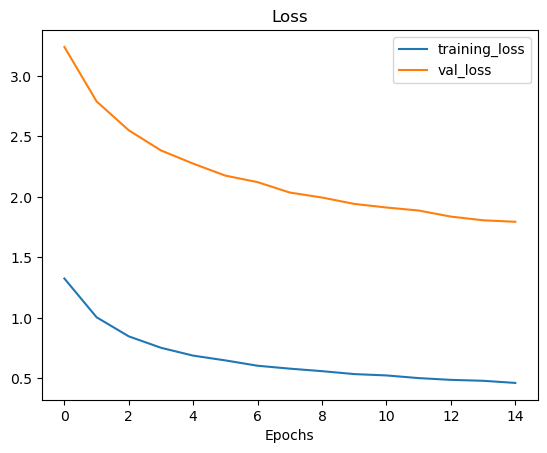

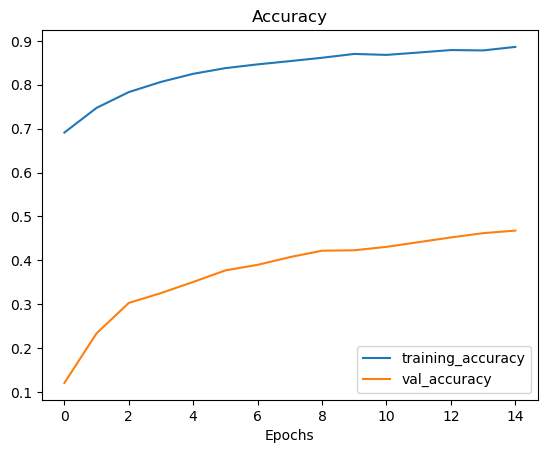

In [10]:
plot_loss_curves(history_15_epocks)

## Save the model and then try to improve it

In [11]:
model.save('model_15_epocks_no_fine_tuning.h5')

### add 5 more epocks

In [12]:



# Refit the model (same as model_2 except with more trainable layers)
history_20_epocks = model.fit(train,
                                               epochs=20,
                                               validation_data=validate,
                                               initial_epoch=history_15_epocks.epoch[-1], # start from previous last epoch
                                               validation_steps=len(validate),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "model_fine_tune_last_10")]) # name experiment appropriately



Saving TensorBoard log files to: transfer_learning/model_fine_tune_last_10/20230111-135743
Epoch 15/20
451/451 [==============================] - 38s 83ms/step - loss: 0.4539 - accuracy: 0.8872 - val_loss: 1.7596 - val_accuracy: 0.4825
Epoch 16/20
451/451 [==============================] - 37s 83ms/step - loss: 0.4447 - accuracy: 0.8915 - val_loss: 1.7541 - val_accuracy: 0.4805
Epoch 17/20
451/451 [==============================] - 37s 83ms/step - loss: 0.4359 - accuracy: 0.8906 - val_loss: 1.7280 - val_accuracy: 0.4795
Epoch 18/20
451/451 [==============================] - 38s 84ms/step - loss: 0.4284 - accuracy: 0.8930 - val_loss: 1.7173 - val_accuracy: 0.4737
Epoch 19/20
451/451 [==============================] - 37s 82ms/step - loss: 0.4218 - accuracy: 0.8942 - val_loss: 1.7147 - val_accuracy: 0.4747
Epoch 20/20
451/451 [==============================] - 38s 84ms/step - loss: 0.4137 - accuracy: 0.8966 - val_loss: 1.6853 - val_accuracy: 0.4854


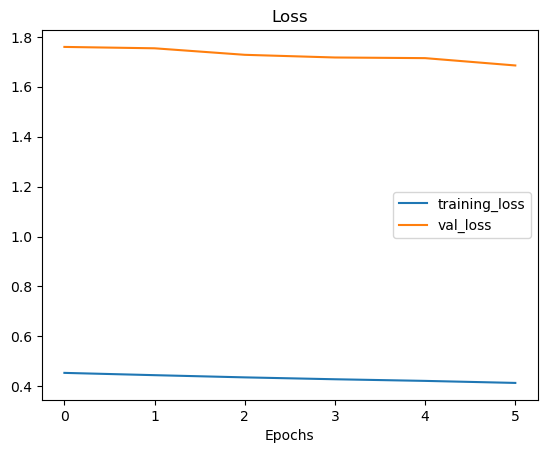

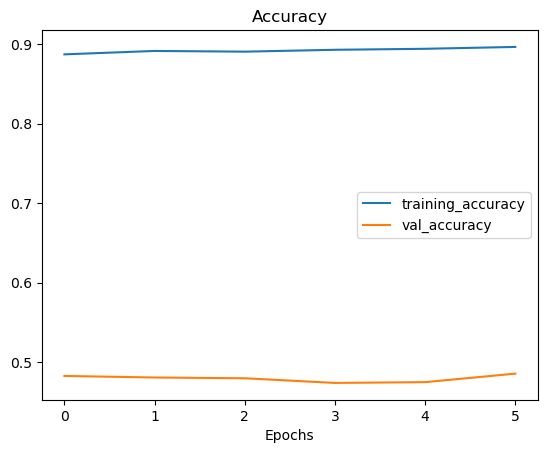

In [13]:
plot_loss_curves(history_20_epocks)

since the model is not improving it is saved

In [15]:
model.save('model_20_epocks_no_fine_tuning.h5')

## Fine Tuning
First lest's unfreeze 10, layers lower the learning rate by factor of 10 and train it for 5 epocks

In [16]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

C:\Users\48517\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


See which laers are freezed and which got unfreezed

In [17]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [18]:



# Refit the model (same as model_2 except with more trainable layers)
history_25_epocks_fine_tuned = model.fit(train,
                                               epochs=25,
                                               validation_data=validate,
                                               initial_epoch=history_20_epocks.epoch[-1], # start from previous last epoch
                                               validation_steps=len(validate),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "model_fine_tune_last_10")]) # name experiment appropriately



Saving TensorBoard log files to: transfer_learning/model_fine_tune_last_10/20230111-140702
Epoch 20/25
451/451 [==============================] - 47s 89ms/step - loss: 0.8100 - accuracy: 0.7591 - val_loss: 2.3041 - val_accuracy: 0.3723
Epoch 21/25
451/451 [==============================] - 39s 87ms/step - loss: 0.6205 - accuracy: 0.8052 - val_loss: 2.2294 - val_accuracy: 0.4025
Epoch 22/25
451/451 [==============================] - 39s 87ms/step - loss: 0.5027 - accuracy: 0.8460 - val_loss: 2.6180 - val_accuracy: 0.3713
Epoch 23/25
451/451 [==============================] - 39s 88ms/step - loss: 0.4477 - accuracy: 0.8596 - val_loss: 3.0436 - val_accuracy: 0.3704
Epoch 24/25
451/451 [==============================] - 39s 87ms/step - loss: 0.3987 - accuracy: 0.8735 - val_loss: 3.4327 - val_accuracy: 0.3869
Epoch 25/25
451/451 [==============================] - 39s 87ms/step - loss: 0.3555 - accuracy: 0.8862 - val_loss: 3.9065 - val_accuracy: 0.3879


Unfortunatly the model got worse

## Load model after 20 epocks and evaluate it on test dataset

In [19]:
model = tf.keras.models.load_model('model_20_epocks_no_fine_tuning.h5')

In [20]:
# Make predictions with model
pred_probs = model.predict(test)

31/31 [==============================] - 3s 62ms/step


In [21]:
# Get the class names
class_names = validate.class_names
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y']

In [24]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

In [25]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

In [26]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5510616784630941

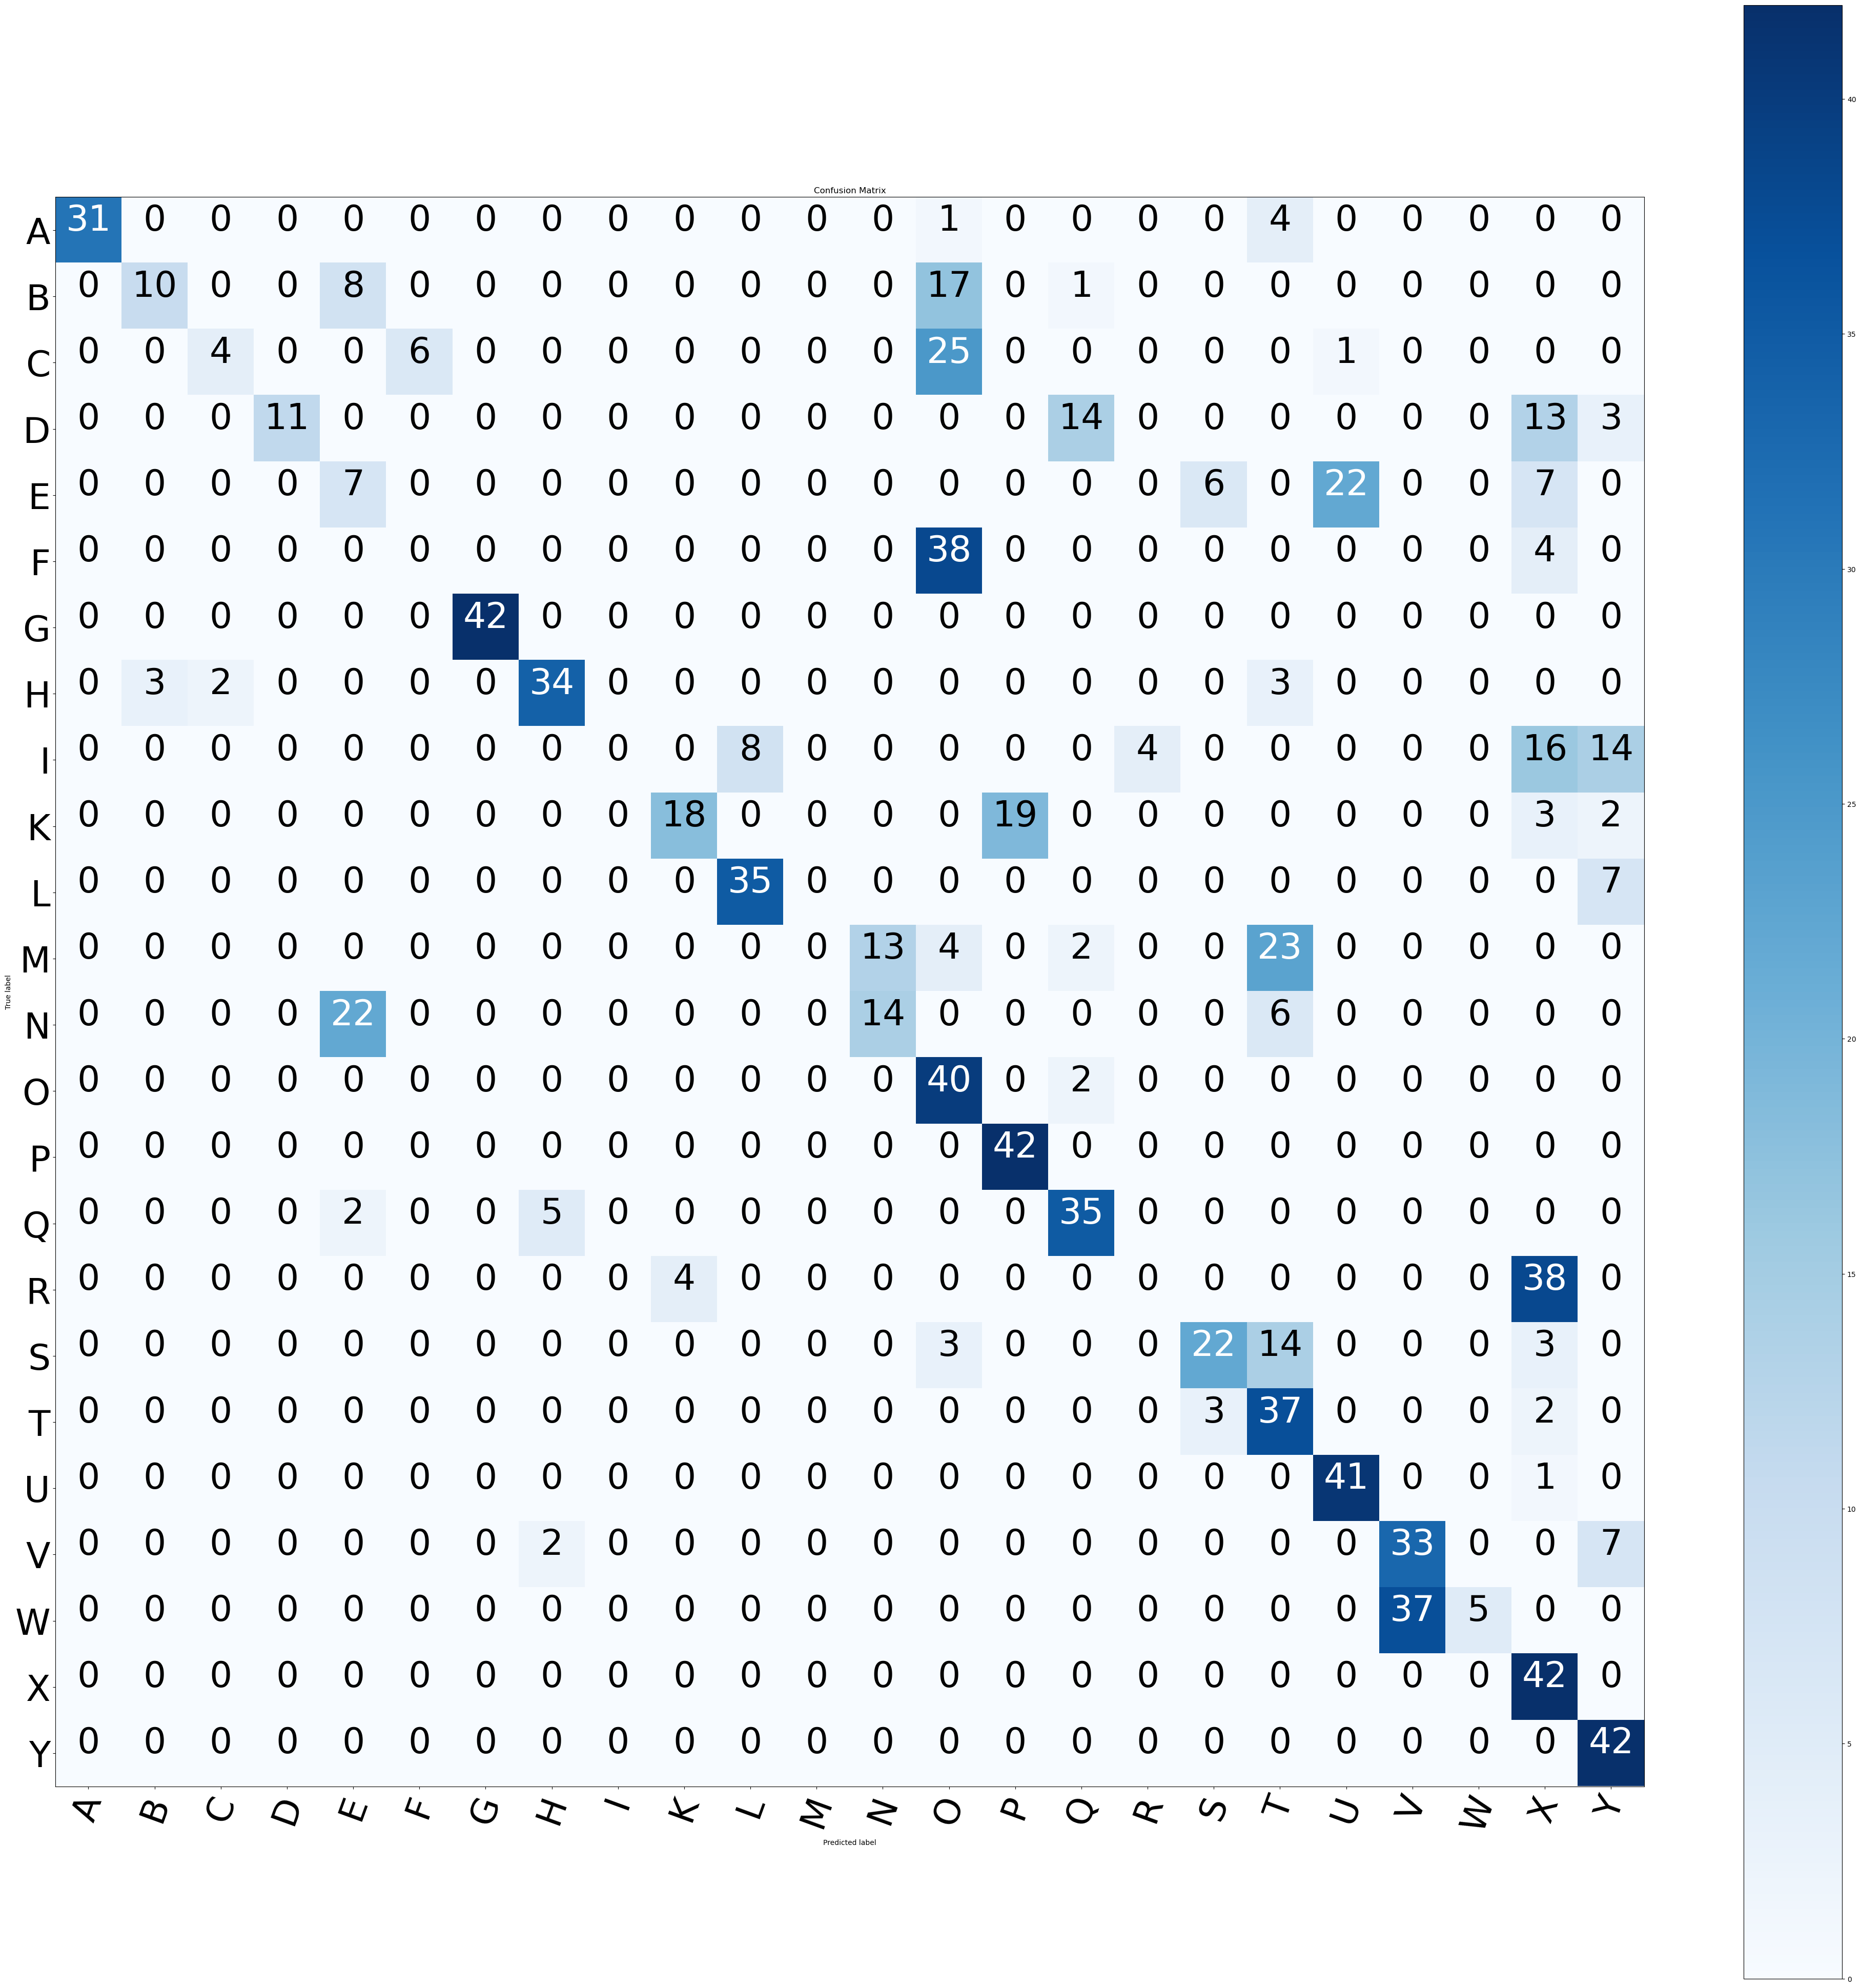

In [27]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(50, 50),
                      text_size=50,
                      norm=False,
                      savefig=True)